In [9]:
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
import random
random.seed(42)

import os
import subprocess
from tqdm import tqdm
from os import makedirs
from gaussian_renderer import render_lie, render_qtvec
import torchvision
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args, pose_estimation_params
from gaussian_renderer import GaussianModel
from utils.image_utils import psnr
from utils.loss_utils import EdgeDetection
import numpy as np
from utils.loss_utils import l1_loss, ssim, l2_loss
from copy import deepcopy
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS
import pypose as pp

from scene.dataset_readers import readColmapSceneInfo
from utils.camera_utils import loadCam
from collections import namedtuple
from matplotlib import pyplot as plt


import torch
import math
from diff_gaussian_rasterization_lie_pp import GaussianRasterizationSettings, GaussianRasterizer
from scene.gaussian_model import GaussianModel
from utils.sh_utils import eval_sh

import pickle

from scene.dataset_readers import CameraInfo
from PIL import Image
import mrob
import open3d as o3d

from arguments import  pose_estimation_params
from utils.general_utils import get_expon_lr_func
import cv2
from glob import glob
import copy
import json

import kernels
import torch.nn.functional as torch_F

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:
def interp_schedule(x, schedule, left=0, right=1):
    # linear interprete between a list of schedule values
    assert left <= x and right >= x
    if isinstance(schedule, torch.Tensor):
        schedule = schedule.cpu().detach().numpy()
    if isinstance(x, torch.Tensor):
        x = x.cpu().detach().numpy()
    xs = np.linspace(left, right, len(schedule))
    return np.interp(x, xs, schedule)

def get_number_of_max_iou_iters(num, max_iters=64):
    return num if num < max_iters else max_iters

def get_render_func(camera_type):
    if camera_type == 'qtvec':
        render = render_qtvec
    elif camera_type == 'lietorch':
        render = render_lie
    return render

def get_loss_func(loss_type):
    if loss_type == 'l1':
        loss_func = l1_loss
    elif loss_type == 'l2':
        loss_func = l2_loss
    return loss_func

def get_optimizer_func(optimizer_type):
    if optimizer_type == 'adam':
        optimizer_func = torch.optim.Adam
    return optimizer_func

def image_torch_to_np(image_init):
    norm_image = cv2.normalize(image_init.squeeze().detach().cpu().numpy().transpose(1,2,0), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_image = norm_image.astype(np.uint8)
    return norm_image

class Solver:
    def __init__(self, camera, optimizer_func, camera_pose_estimation_params):
        
        self.pose_optimizer = optimizer_func([{'params': camera.world_view_transform_, 
                                                 'lr': camera_pose_estimation_params.pose_lr_init, "name": "pose"}], 
                                               lr = camera_pose_estimation_params.pose_lr_init)
        self.pose_scheduler_args = get_expon_lr_func(lr_init=camera_pose_estimation_params.pose_lr_init,
                            lr_final=camera_pose_estimation_params.pose_lr_final,
                            lr_delay_steps=camera_pose_estimation_params.pose_lr_delay_steps, 
                            lr_delay_mult=camera_pose_estimation_params.pose_lr_delay_mult,
                            max_steps=camera_pose_estimation_params.pose_lr_max_steps)
        
    def update_learning_rate_pose(self, iteration, factor = 1):
        ''' Learning rate scheduling per step '''
        for param_group in self.pose_optimizer.param_groups:
            if param_group["name"] == "pose":
                if type(self.pose_scheduler_args) == list:
                    lr = self.pose_scheduler_args[iteration] * factor
                else:
                    lr = self.pose_scheduler_args(iteration) * factor
                param_group['lr'] = lr
                return lr


def solve_vanilla(cam_info_init, task_info, gaussians, solving_args = None):
    args = namedtuple('args', ['resolution', 'data_device'])
    args = args(task_info['init_render_resolution'], 'cuda')
    pipe = namedtuple('pipe', ['convert_SHs_python', 'compute_cov3D_python', 'debug'])
    pipe = pipe(False, False, False)
    bg_color = [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    camera_type = task_info['camera_type']
    loss_type = task_info['loss_type']
    optimizer_type = task_info['optimizer_type']

    iterations = task_info['iterations']
    exit_psnr_parameter = task_info['exit_psnr_parameter']

    pose_lr_init = task_info['pose_lr_init']
    pose_lr_final = task_info['pose_lr_final']
    pose_lr_delay_steps = task_info['pose_lr_delay_steps']
    pose_lr_delay_mult = task_info['pose_lr_delay_mult']

    render_func = get_render_func(camera_type)
    loss_func = get_loss_func(loss_type)
    optimizer_func = get_optimizer_func(optimizer_type)

    # camera_gt = loadCam(args=args, id = 0, cam_info=cam_info_gt, resolution_scale=1, camera_type=camera_type)
    camera_init = loadCam(args=args, id = 0, cam_info=cam_info_init, resolution_scale=1, camera_type=camera_type)

    pose_solver = Solver(camera_init, optimizer_func, pose_estimation_params(pose_lr_init, pose_lr_final, pose_lr_delay_steps,
                                                            pose_lr_delay_mult, iterations, False))

    prev_psnr = 1000
    max_psnr = -1
    init_psnr = 0

    lpips = LPIPS(normalize=True).cuda()
    init_qtvec = camera_init.world_view_transform_
    rendering_init = torch.clamp(render_func(camera_init, gaussians, pipe, background)["render"], 0, 1)
    gt_image = camera_init.original_image.cuda()

    # progress_bar = tqdm(range(0, iterations), desc="Optimizing camera " + str(camera_gt.image_name))
    if camera_type == 'lietorch':
        best_viewpoint_cam = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
    else:
        best_viewpoint_cam = camera_init.world_view_transform_
    converged = False
    counter = 0
    for iteration in range(0, iterations):        
        image = render_func(camera_init, gaussians, pipe, background)["render"]
        image = torch.clamp(image, 0, 1)
        L1 = loss_func(image, gt_image)
        loss_value = L1
        psnr_value = psnr(image, gt_image).mean().item()
        loss_value.backward()

        if iteration == 0:
            loss_init = loss_value.item()

        if psnr_value >= max_psnr:
            max_psnr = psnr_value 
            if camera_type == 'lietorch':
                best_viewpoint_cam = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
            else:
                best_viewpoint_cam = camera_init.world_view_transform_

        if abs(psnr_value - prev_psnr) <= exit_psnr_parameter:
            counter += 1
            if counter == 3:
                converged = True
                print('Converged. PSNR optimized as: ' \
                + format(init_psnr, '.7f') + ' -> ' + format(max_psnr, '.7f'))
                counter = 0
                # progress_bar.close()
                break

        # progress_bar.set_postfix({"Loss": f"{loss_value.item():.{7}f}", 'PSNR' : f"{psnr_value:.{7}f}"})
        # progress_bar.update()
        prev_psnr = psnr_value
        
        init_psnr = psnr_value if iteration == 0 else init_psnr

        with torch.no_grad():
            if camera_type == 'lietorch':
                camera_init.world_view_transform_.grad = camera_init.world_view_transform.grad[:-1].unsqueeze(0)
            pose_solver.update_learning_rate_pose(iteration)
            pose_solver.pose_optimizer.step()
            pose_solver.pose_optimizer.zero_grad(set_to_none = True)
            if camera_type == 'lietorch':
                camera_init.world_view_transform = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
    # progress_bar.close()

    if camera_type == 'lietorch':
        camera_init.world_view_transform  = best_viewpoint_cam
    else:
        camera_init.world_view_transform_ = best_viewpoint_cam 

    rendering_result = torch.clamp(render_func(camera_init, gaussians, pipe, background)['render'], 0, 1)
    result_psnr = psnr(rendering_result, gt_image).mean().item()
    result_ssim = ssim(rendering_result, gt_image).mean().item()
    result_lpips = lpips(rendering_result.unsqueeze(0), gt_image.unsqueeze(0)).mean().item()

    init_psnr = psnr(rendering_init, gt_image).mean().item()
    init_ssim = ssim(rendering_init, gt_image).mean().item()
    init_lpips = lpips(rendering_init.unsqueeze(0), gt_image.unsqueeze(0)).mean().item()

    success = 1 if result_psnr > 27 else 0

    return {'qtvec_init':init_qtvec.detach().cpu().numpy(),
            'psnr_init':init_psnr,
            'ssim_init':init_ssim,
            'lpips_init':init_lpips,
            'loss_init':loss_init,
            'image_init':image_torch_to_np(rendering_init),
            'image_gt':image_torch_to_np(gt_image),

            'qtvec_result':best_viewpoint_cam.detach().cpu().numpy(),
            'psnr_result':result_psnr,
            'ssim_result':result_ssim,
            'lpips_result':result_lpips,
            'loss_result':loss_value.item(),
            'image_result':image_torch_to_np(rendering_result),
            'iterations_to_result':iteration,
            'converged':converged,
            'success':success,
            }

def blur_image(gt_image, iteration, iterations, max_scale, blur_2d_c2f_kernel_size, blur_2d_c2f_schedule):
    H = gt_image.shape[1]
    W = gt_image.shape[2]
    c2f_alternate_2D_mode = False
    device = torch.device('cuda')

    # blur_2d_c2f_schedule = [0.05, 0.025, 0.0125, 0.00625, 0.00625, 0.0, 0.0, 0.0, 0.0, 0.0]
    # blur_2d_c2f_schedule = [0.025, 0.0125, 0.00625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    # blur_2d_c2f_kernel_size = 201
    # max_scale = 1

    if c2f_alternate_2D_mode == "sample":
        scales = [0.0, 0.25, 0.5, 0.75, 1.0]
    else:
        scales = [0.0, max_scale]
    # get kernels
    kernels_dict = dict() # dictionary from scale to kernel
    for sc in scales:
        blur_param = interp_schedule(float(iteration/iterations), blur_2d_c2f_schedule)
        blur_param = torch.tensor(blur_param, device=device)
        blur_param *= sc
        # get kernel

        kernel_width = blur_param * (W + H)/2
        kernel_1d = kernels.get_gaussian_kernel(kernel_width, blur_2d_c2f_kernel_size)

        kernel_1d = kernel_1d.to(device=device,dtype=torch.float32)

        kernel_1d = kernel_1d.expand(1,1,-1)

        kernels_dict[sc] = (kernel_1d, kernel_width)

    # generte blurred GT images
    blurred_gt_cached_images = dict()

    for sc, k in kernels_dict.items():
        kernel_1d, kernel_width = k
        # skip kernel if kernel_width too small
        if kernel_width < 0.01:
            images = gt_image
        else:
            # perform 2D seperated convolution
            images = gt_image
            kernel_size = kernel_1d.shape[-1]
            pad_size= (kernel_size //2, kernel_size //2)
            images = torch_F.pad(images, pad_size, mode="replicate")
            images = torch_F.conv1d(images, kernel_1d.expand(H,1,-1), bias=None, stride=1, padding=0, dilation=1, groups=H)
            images = images.permute(0,2,1)
            images = torch_F.pad(images, pad_size, mode="replicate")
            images = torch_F.conv1d(images, kernel_1d.expand(W,1,-1), bias=None, stride=1, padding=0, dilation=1, groups=W)
            images = images.permute(0,2,1).reshape(1, 3, H, W).contiguous()
        blurred_gt_cached_images[sc] = images
    return blurred_gt_cached_images


def solve_coarse(cam_info_init, task_info, gaussians, solving_args = None):
    args = namedtuple('args', ['resolution', 'data_device'])
    args = args(task_info['init_render_resolution'], 'cuda')
    pipe = namedtuple('pipe', ['convert_SHs_python', 'compute_cov3D_python', 'debug'])
    pipe = pipe(False, False, False)
    bg_color = [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    camera_type = task_info['camera_type']
    loss_type = task_info['loss_type']
    optimizer_type = task_info['optimizer_type']

    iterations = task_info['iterations']
    exit_psnr_parameter = task_info['exit_psnr_parameter']

    pose_lr_init = task_info['pose_lr_init']
    pose_lr_final = task_info['pose_lr_final']
    pose_lr_delay_steps = task_info['pose_lr_delay_steps']
    pose_lr_delay_mult = task_info['pose_lr_delay_mult']

    render_func = get_render_func(camera_type)
    loss_func = get_loss_func(loss_type)
    optimizer_func = get_optimizer_func(optimizer_type)

    # camera_gt = loadCam(args=args, id = 0, cam_info=cam_info_gt, resolution_scale=1, camera_type=camera_type)
    camera_init = loadCam(args=args, id = 0, cam_info=cam_info_init, resolution_scale=1, camera_type=camera_type)

    pose_solver = Solver(camera_init, optimizer_func, pose_estimation_params(pose_lr_init, pose_lr_final, pose_lr_delay_steps,
                                                        pose_lr_delay_mult, iterations, False))
    
    num_tries = solving_args['num_tries']
    max_scale_ = solving_args['max_scale']
    blur_2d_c2f_kernel_size = solving_args['blur_2d_c2f_kernel_size']
    blur_2d_c2f_schedule = solving_args['blur_2d_c2f_schedule']
    
    current_try = 0
    success = 0

    while current_try < num_tries and success == 0:
        # if current_try > 1:
        #     max_scale += 1
        prev_psnr = 1000
        max_psnr = -1
        init_psnr = 0

        lpips = LPIPS(normalize=True).cuda()
        init_qtvec = camera_init.world_view_transform_
        if current_try == 0:
            rendering_init = torch.clamp(render_func(camera_init, gaussians, pipe, background)["render"], 0, 1)
        gt_image = camera_init.original_image.cuda()

        progress_bar = tqdm(range(0, iterations), desc="Optimizing camera ")
        if camera_type == 'lietorch':
            best_viewpoint_cam = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
        else:
            best_viewpoint_cam = camera_init.world_view_transform_
        converged = False
        counter = 0
        
        for iteration in range(0, iterations):        
            image = render_func(camera_init, gaussians, pipe, background)["render"]
            image = torch.clamp(image, 0, 1)
            max_scale = np.random.rand()*max_scale_
            gt_image_blur_dict = blur_image(gt_image, iteration, 
                                            iterations, max_scale=max_scale, 
                                            blur_2d_c2f_kernel_size = blur_2d_c2f_kernel_size,
                                            blur_2d_c2f_schedule = blur_2d_c2f_schedule)
            image_blur_dict = blur_image(image, iteration, 
                                         iterations, max_scale=max_scale, 
                                        blur_2d_c2f_kernel_size = blur_2d_c2f_kernel_size,
                                        blur_2d_c2f_schedule = blur_2d_c2f_schedule)

            L1 = loss_func(image_blur_dict[max_scale], gt_image_blur_dict[max_scale])
            loss_value = L1
            psnr_value = psnr(image, gt_image).mean().item()
            loss_value.backward()

            if iteration == 0 and current_try == 0:
                loss_init = loss_value.item()

            if psnr_value >= max_psnr:
                max_psnr = psnr_value 
                if camera_type == 'lietorch':
                    best_viewpoint_cam = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
                else:
                    best_viewpoint_cam = camera_init.world_view_transform_

            if abs(psnr_value - prev_psnr) <= exit_psnr_parameter:
                counter += 1
                if counter == 3:
                    converged = True
                    print('Converged. PSNR optimized as: ' \
                    + format(init_psnr, '.7f') + ' -> ' + format(max_psnr, '.7f'))
                    counter = 0
                    progress_bar.close()
                    break
            
            progress_bar.set_postfix({"Loss": f"{loss_value.item():.{7}f}", 'PSNR' : f"{psnr_value:.{7}f}", 'max_scale' : f"{max_scale:.{4}f}"})
            progress_bar.update()
            prev_psnr = psnr_value
            
            init_psnr = psnr_value if iteration == 0 else init_psnr

            with torch.no_grad():
                if camera_type == 'lietorch':
                    camera_init.world_view_transform_.grad = camera_init.world_view_transform.grad[:-1].unsqueeze(0)
                pose_solver.update_learning_rate_pose(iteration)
                pose_solver.pose_optimizer.step()
                pose_solver.pose_optimizer.zero_grad(set_to_none = True)
                if camera_type == 'lietorch':
                    camera_init.world_view_transform = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
        progress_bar.close()

        if camera_type == 'lietorch':
            camera_init.world_view_transform  = best_viewpoint_cam
        else:
            camera_init.world_view_transform_ = best_viewpoint_cam 

        rendering_result = torch.clamp(render_func(camera_init, gaussians, pipe, background)['render'], 0, 1)
        result_psnr = psnr(rendering_result, gt_image).mean().item()
        result_ssim = ssim(rendering_result, gt_image).mean().item()
        result_lpips = lpips(rendering_result.unsqueeze(0), gt_image.unsqueeze(0)).mean().item()

        if current_try == 0:
            init_psnr = psnr(rendering_init, gt_image).mean().item()
            init_ssim = ssim(rendering_init, gt_image).mean().item()
            init_lpips = lpips(rendering_init.unsqueeze(0), gt_image.unsqueeze(0)).mean().item()

        success = 1 if result_psnr > 27 else 0
        current_try += 1
    

    return {'qtvec_init':init_qtvec.detach().cpu().numpy(),
            'psnr_init':init_psnr,
            'ssim_init':init_ssim,
            'lpips_init':init_lpips,
            'loss_init':loss_init,
            'image_init':image_torch_to_np(rendering_init),
            'image_gt':image_torch_to_np(gt_image),

            'qtvec_result':best_viewpoint_cam.detach().cpu().numpy(),
            'psnr_result':result_psnr,
            'ssim_result':result_ssim,
            'lpips_result':result_lpips,
            'loss_result':loss_value.item(),
            'image_result':image_torch_to_np(rendering_result),
            'iterations_to_result':iteration,
            'converged':converged,
            'success':success,
            }


def get_solving_func(solving_method):
    if solving_method == 'vanilla':
        solving_func = solve_vanilla
    if solving_method == 'coarse':
        solving_func = solve_coarse
    return solving_func

In [22]:
room_name = pickle_path_orig.split('/')[-4]
frame_id = int(pickle_path_orig.split('/')[-3])
iou_bin = float('0.' + pickle_path_orig.split('/')[-2][1:])
index = int(pickle_path_orig.split('/')[-1].split('_')[0])

solving_method_args = { 
                        'max_scale':2,
                        'num_tries':5,
                        'blur_2d_c2f_kernel_size':201,
                        'blur_2d_c2f_schedule':[0.05, 0.025, 0.0125, 0.00625, 0.00625, 0.0, 0.0, 0.0, 0.0, 0.0],
                       }

In [29]:
task_info = {  
                        'room_name':room_name,
                        'camera_type':'lietorch',
                        # 'camera_type':'qtvec',
                        'solving_method':'coarse',
                        # 'solving_method':'vanilla',
                        'solving_method_args': solving_method_args,
                        'loss_type':'l1',
                        'optimizer_type':'adam',
                        'init_render_resolution':2,
                        'iterations':2000,
                        'exit_psnr_parameter':1e-5,
                        'pose_lr_init':0.01,
                        'pose_lr_final':1e-5,
                        'pose_lr_delay_steps':0,
                        'pose_lr_delay_mult':0, 
                        'start_frame':0,
                        'last_frame':32,
                        'experiments_base_dir':'/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/'
                    }

In [24]:
room_name = task_info['room_name']

experiments_base_dir = task_info['experiments_base_dir']

ply_path = os.path.join(experiments_base_dir, 
                        'output', room_name, 
                        'point_cloud/iteration_40000/point_cloud.ply')

gaussians = GaussianModel(sh_degree=3)
gaussians.load_ply(ply_path)

In [25]:
# frame_id = 28
# iou_bin = 0.30
# index = 31

pickle_path = os.path.join(experiments_base_dir, 'scenes', room_name, room_name + '_task', 'images_pairs_light', str(frame_id).zfill(5) + '.pickle')
with open(pickle_path, 'rb') as handle:
    frames_info = pickle.load(handle)

In [26]:
solving_method = task_info['solving_method']
solving_args = task_info['solving_method_args']
solve_func = get_solving_func(solving_method=solving_method)


FovY = frames_info['frames']['FovY']
FovX = frames_info['frames']['FovX']
width = frames_info['frames']['width']
height = frames_info['frames']['height']
cx = frames_info['frames']['cx']
cy = frames_info['frames']['cy']

image_gt = Image.fromarray(frames_info['frames']['image'])
image_path = frames_info['frames']['img_path']
image_name = frames_info['img_name']
R_gt = frames_info['frames']['R']
t_gt = frames_info['frames']['T']

# cam_info_gt = CameraInfo(uid=0, R=R_gt, T=t_gt, FovY=FovY, FovX=FovX, image=image_gt,
#                          image_path=image_path, image_name=image_name, width=width,
#                          height=height, qvec = None, cx = cx, cy = cy)

image_init = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['init_image']
R_init = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['R_init']
t_init = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['T_init']

cam_info_init = CameraInfo(uid=0, R=R_init, T=t_init, FovY=FovY, FovX=FovX, image=image_gt,
                        image_path=image_path, image_name=image_name, width=width,
                        height=height, qvec = None, cx = cx, cy = cy)

iou_value = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['iou']
black_pixels_ratio = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['black_pixels_ratio']
init_outside = True if black_pixels_ratio > 0.3 else False

In [27]:
result = solve_func(cam_info_init=cam_info_init, task_info=task_info, gaussians=gaussians, solving_args=solving_args)

output_result = copy.copy(task_info)
output_result['image_original_path'] = frames_info['frames']['img_path']
output_result['width_original'] = frames_info['frames']['width']
output_result['height_original'] = frames_info['frames']['height']
output_result['cx_original'] = frames_info['frames']['cx']
output_result['cy_original'] = frames_info['frames']['cy']
output_result['FovX'] = frames_info['frames']['FovX']
output_result['FovY'] = frames_info['frames']['FovY']

output_result['R_gt'] = frames_info['frames']['R']
output_result['t_gt'] = frames_info['frames']['T']
output_result['qvec_gt'] = frames_info['frames']['qvec']
output_result['iou_value'] = iou_value

output_result = output_result | result

Optimizing camera :  33%|███▎      | 660/2000 [00:55<01:52, 11.91it/s, Loss=0.2298823, PSNR=11.7867689, max_scale=0.0789]


Converged. PSNR optimized as: 9.9465780 -> 11.8816624


Optimizing camera :  26%|██▋       | 527/2000 [00:53<02:28,  9.90it/s, Loss=0.1523753, PSNR=12.1998825, max_scale=1.7306]


Converged. PSNR optimized as: 11.7867680 -> 12.1998882


Optimizing camera :  32%|███▏      | 643/2000 [01:15<02:40,  8.47it/s, Loss=0.1799784, PSNR=12.0867481, max_scale=0.4151]


Converged. PSNR optimized as: 12.1998882 -> 12.2721281


Optimizing camera :  33%|███▎      | 656/2000 [01:19<02:41,  8.30it/s, Loss=0.1823427, PSNR=12.1034203, max_scale=0.2869]


Converged. PSNR optimized as: 12.0867414 -> 12.1770992


Optimizing camera :  25%|██▌       | 508/2000 [00:43<02:08, 11.57it/s, Loss=0.1621630, PSNR=12.1199522, max_scale=1.0893]


Converged. PSNR optimized as: 12.1034203 -> 12.1923199


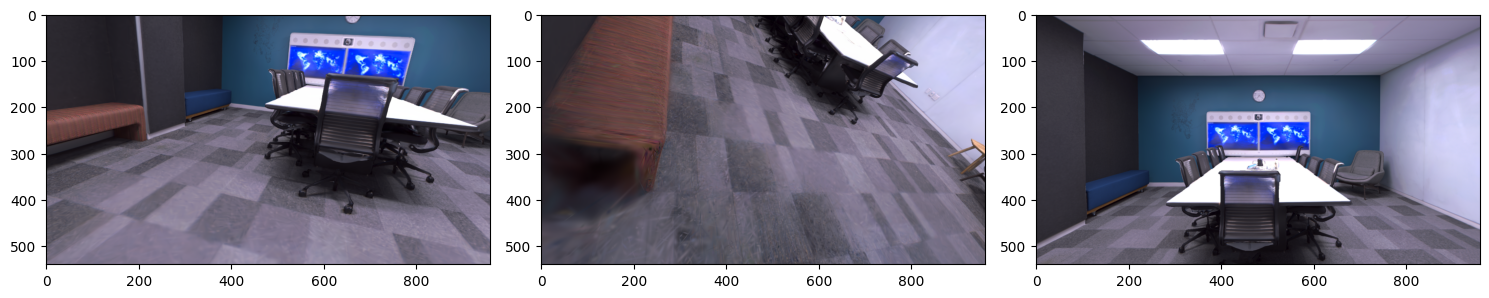

In [28]:
f, axarr = plt.subplots(1,3, figsize = (15,5))
axarr[0].imshow((result['image_init']))
axarr[1].imshow((result['image_result']))
axarr[2].imshow(result['image_gt'])
plt.tight_layout()
plt.show()

In [380]:
args = namedtuple('args', ['resolution', 'data_device'])
args = args(task_info['init_render_resolution'], 'cuda')
pipe = namedtuple('pipe', ['convert_SHs_python', 'compute_cov3D_python', 'debug'])
pipe = pipe(False, False, False)
bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

camera_type = task_info['camera_type']
loss_type = task_info['loss_type']
optimizer_type = task_info['optimizer_type']

iterations = task_info['iterations']
exit_psnr_parameter = task_info['exit_psnr_parameter']

pose_lr_init = task_info['pose_lr_init']
pose_lr_final = task_info['pose_lr_final']
pose_lr_delay_steps = task_info['pose_lr_delay_steps']
pose_lr_delay_mult = task_info['pose_lr_delay_mult']

render_func = get_render_func(camera_type)
loss_func = get_loss_func(loss_type)
optimizer_func = get_optimizer_func(optimizer_type)

# camera_gt = loadCam(args=args, id = 0, cam_info=cam_info_gt, resolution_scale=1, camera_type=camera_type)
camera_init = loadCam(args=args, id = 0, cam_info=cam_info_init, resolution_scale=1, camera_type=camera_type)

In [382]:
pose_solver = Solver(camera_init, optimizer_func, pose_estimation_params(pose_lr_init, pose_lr_final, pose_lr_delay_steps,
                                                        pose_lr_delay_mult, iterations, False))

prev_psnr = 1000
max_psnr = -1
init_psnr = 0

lpips = LPIPS(normalize=True).cuda()
init_qtvec = camera_init.world_view_transform_
rendering_init = torch.clamp(render_func(camera_init, gaussians, pipe, background)["render"], 0, 1)
gt_image = camera_init.original_image.cuda()

progress_bar = tqdm(range(0, iterations), desc="Optimizing camera ")
if camera_type == 'lietorch':
    best_viewpoint_cam = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
else:
    best_viewpoint_cam = camera_init.world_view_transform_
converged = False
counter = 0
for iteration in range(0, iterations):        
    image = render_func(camera_init, gaussians, pipe, background)["render"]
    image = torch.clamp(image, 0, 1)

    max_scale = 2

    # max_scale = np.random.rand()*3

    gt_image_blur_dict = blur_image(gt_image, iteration, iterations, max_scale=max_scale)
    image_blur_dict = blur_image(image, iteration, iterations, max_scale=max_scale)

    # edge_mask = get_edge_mask(gt_image_blur_dict, max_scale=max_scale)
    # edge_mask = torch.ones_like(edge_mask[max_scale]) + edge_mask[max_scale]

    # edge_mask

    # L1 = loss_func(image, gt_image)
    L1 = loss_func(image_blur_dict[max_scale], gt_image_blur_dict[max_scale])
    # L1 = loss_func(image_blur_dict[max_scale].squeeze().reshape(3,-1)*edge_mask.squeeze(), 
    #                gt_image_blur_dict[max_scale].squeeze().reshape(3,-1)*edge_mask.squeeze())
    loss_value = L1
    psnr_value = psnr(image, gt_image).mean().item()
    loss_value.backward()


    if iteration == 0:
        loss_init = loss_value.item()

    if psnr_value >= max_psnr:
        max_psnr = psnr_value 
        if camera_type == 'lietorch':
            best_viewpoint_cam = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
        else:
            best_viewpoint_cam = camera_init.world_view_transform_

    if abs(psnr_value - prev_psnr) <= exit_psnr_parameter:
        counter += 1
        if counter == 3:
            converged = True
            print('Converged. PSNR optimized as: ' \
            + format(init_psnr, '.7f') + ' -> ' + format(max_psnr, '.7f'))
            counter = 0
            progress_bar.close()
            break
    
    progress_bar.set_postfix({"Loss": f"{loss_value.item():.{7}f}", 'PSNR' : f"{psnr_value:.{7}f}"})
    progress_bar.update()
    prev_psnr = psnr_value
    
    init_psnr = psnr_value if iteration == 0 else init_psnr

    with torch.no_grad():
        if camera_type == 'lietorch':
            camera_init.world_view_transform_.grad = camera_init.world_view_transform.grad[:-1].unsqueeze(0)
        pose_solver.update_learning_rate_pose(iteration)
        pose_solver.pose_optimizer.step()
        pose_solver.pose_optimizer.zero_grad(set_to_none = True)
        if camera_type == 'lietorch':
            camera_init.world_view_transform = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
progress_bar.close()

if camera_type == 'lietorch':
    camera_init.world_view_transform  = best_viewpoint_cam
else:
    camera_init.world_view_transform_ = best_viewpoint_cam 

rendering_result = torch.clamp(render_func(camera_init, gaussians, pipe, background)['render'], 0, 1)
result_psnr = psnr(rendering_result, gt_image).mean().item()
result_ssim = ssim(rendering_result, gt_image).mean().item()
result_lpips = lpips(rendering_result.unsqueeze(0), gt_image.unsqueeze(0)).mean().item()

init_psnr = psnr(rendering_init, gt_image).mean().item()
init_ssim = ssim(rendering_init, gt_image).mean().item()
init_lpips = lpips(rendering_init.unsqueeze(0), gt_image.unsqueeze(0)).mean().item()

success = 1 if result_psnr > 27 else 0

result =  {'qtvec_init':init_qtvec.detach().cpu().numpy(),
        'psnr_init':init_psnr,
        'ssim_init':init_ssim,
        'lpips_init':init_lpips,
        'loss_init':loss_init,
        'image_init':image_torch_to_np(rendering_init),
        'image_gt':image_torch_to_np(gt_image),

        'qtvec_result':best_viewpoint_cam.detach().cpu().numpy(),
        'psnr_result':result_psnr,
        'ssim_result':result_ssim,
        'lpips_result':result_lpips,
        'loss_result':loss_value.item(),
        'image_result':image_torch_to_np(rendering_result),
        'iterations_to_result':iteration,
        'converged':converged,
        'success':success,
        }

Optimizing camera :  38%|███▊      | 770/2000 [01:01<01:37, 12.60it/s, Loss=0.0067016, PSNR=30.6457253]


Converged. PSNR optimized as: 14.0297689 -> 30.7258663


NameError: name 'rendering_init' is not defined

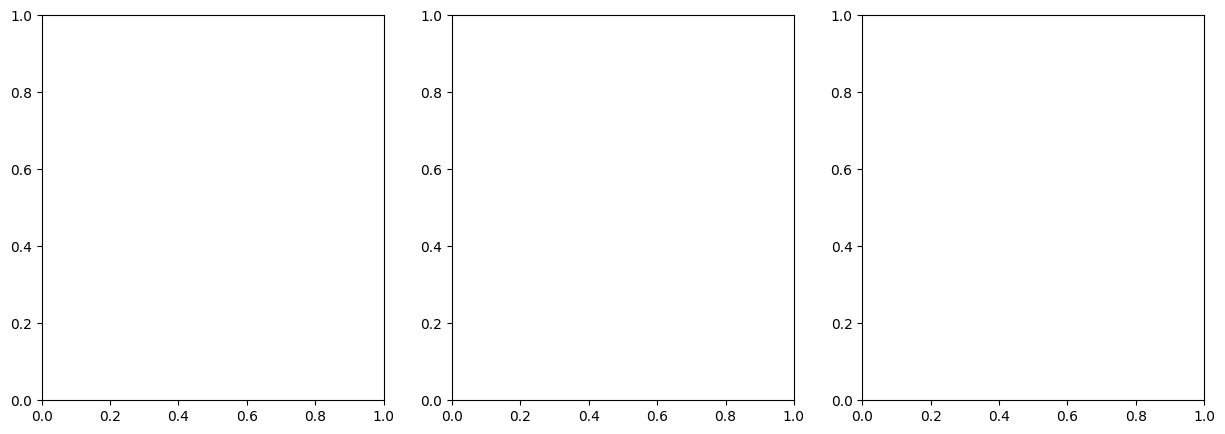

In [378]:
f, axarr = plt.subplots(1,3, figsize = (15,5))
axarr[0].imshow(image_torch_to_np(rendering_init))
axarr[1].imshow(image_torch_to_np(rendering_result))
axarr[2].imshow(image_torch_to_np(gt_image))
plt.tight_layout()
plt.show()

In [226]:
def get_edge_mask(blurred_gt_cached_images, max_scale = 1):
    H = blurred_gt_cached_images[0].shape[1]
    W = blurred_gt_cached_images[0].shape[2]
    device = torch.device('cuda')

    # get kernel scales
    batch_size = 1
    c2f_alternate_2D_mode = False
    c2f_alternate_2D_scale_pool = False
    soft_edge_mask = False
    hard_edge_mask_mean_thresh = False


    if c2f_alternate_2D_mode == "sample":
        scales = c2f_alternate_2D_scale_pool
    else:
        scales = [0.0, max_scale]
    # get kernels
    mask_dict = dict() # dictionary from scale to kernel
    # get sobel kernel
    Kx = torch.tensor([[1,0,-1],
                        [2,0,-2],
                        [1,0,-1]], device=device, dtype=torch.float32)[None,None,...].expand(1,3,-1,-1)

    Ky = torch.tensor([[1,2,1],
                        [0,0,0],
                        [-1,-2,-1]], device=device, dtype=torch.float32)[None, None,...].expand(1,3,-1,-1)
    for sc in scales:
        images = blurred_gt_cached_images[sc]
        pad_size = (1,1,1,1)
        images = torch_F.pad(images, pad_size, mode="replicate")
        Gx = torch_F.conv2d(images, Kx, padding=0)
        Gy = torch_F.conv2d(images, Ky, padding=0)
        GG = torch.sqrt(Gx**2 + Gy**2).view(batch_size,H*W)
        if soft_edge_mask:
            GG_max, _ = GG.max(dim=1,keepdim=True)
            GG_normalized = GG / GG_max
            mask_dict[sc] = GG_normalized
        else:
            GG_mean = GG.mean(dim=(1), keepdim=True)
            thresh = hard_edge_mask_mean_thresh if hard_edge_mask_mean_thresh else 1.25
            GG_bool = (GG>GG_mean*thresh).to(torch.uint8)
            mask_dict[sc] = GG_bool # batch_size , H*W
    return mask_dict

In [106]:

# get kernel scales
def blur_image(gt_image, iteration, iterations, max_scale = 1):
    H = gt_image.shape[1]
    W = gt_image.shape[2]
    c2f_alternate_2D_mode = False
    device = torch.device('cuda')

    blur_2d_c2f_schedule = [0.05, 0.025, 0.0125, 0.00625, 0.00625, 0.0, 0.0, 0.0, 0.0, 0.0]
    # blur_2d_c2f_schedule = [0.025, 0.0125, 0.00625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    blur_2d_c2f_kernel_size = 201

    if c2f_alternate_2D_mode == "sample":
        scales = [0.0, 0.25, 0.5, 0.75, 1.0]
    else:
        scales = [0.0, max_scale]
    # get kernels
    kernels_dict = dict() # dictionary from scale to kernel
    for sc in scales:
        blur_param = interp_schedule(float(iteration/iterations), blur_2d_c2f_schedule)
        blur_param = torch.tensor(blur_param, device=device)
        blur_param *= sc
        # get kernel

        kernel_width = blur_param * (W + H)/2
        kernel_1d = kernels.get_gaussian_kernel(kernel_width, blur_2d_c2f_kernel_size)

        kernel_1d = kernel_1d.to(device=device,dtype=torch.float32)

        kernel_1d = kernel_1d.expand(1,1,-1)

        kernels_dict[sc] = (kernel_1d, kernel_width)

    # generte blurred GT images
    blurred_gt_cached_images = dict()

    for sc, k in kernels_dict.items():
        kernel_1d, kernel_width = k
        # skip kernel if kernel_width too small
        if kernel_width < 0.01:
            images = gt_image
        else:
            # perform 2D seperated convolution
            images = gt_image
            kernel_size = kernel_1d.shape[-1]
            pad_size= (kernel_size //2, kernel_size //2)
            images = torch_F.pad(images, pad_size, mode="replicate")
            images = torch_F.conv1d(images, kernel_1d.expand(H,1,-1), bias=None, stride=1, padding=0, dilation=1, groups=H)
            images = images.permute(0,2,1)
            images = torch_F.pad(images, pad_size, mode="replicate")
            images = torch_F.conv1d(images, kernel_1d.expand(W,1,-1), bias=None, stride=1, padding=0, dilation=1, groups=W)
            images = images.permute(0,2,1).reshape(1, 3, H, W).contiguous()
        blurred_gt_cached_images[sc] = images
    return blurred_gt_cached_images

In [289]:
def get_edge_mask(blurred_gt_cached_images):
    H = blurred_gt_cached_images[0].shape[1]
    W = blurred_gt_cached_images[0].shape[2]
    device = torch.device('cuda')

    # get kernel scales
    batch_size = 1
    c2f_alternate_2D_mode = False
    c2f_alternate_2D_scale_pool = False
    soft_edge_mask = False
    hard_edge_mask_mean_thresh = False


    if c2f_alternate_2D_mode == "sample":
        scales = c2f_alternate_2D_scale_pool
    else:
        scales = [0.0, 1.0]
    # get kernels
    mask_dict = dict() # dictionary from scale to kernel
    # get sobel kernel
    Kx = torch.tensor([[1,0,-1],
                        [2,0,-2],
                        [1,0,-1]], device=device, dtype=torch.float32)[None,None,...].expand(1,3,-1,-1)

    Ky = torch.tensor([[1,2,1],
                        [0,0,0],
                        [-1,-2,-1]], device=device, dtype=torch.float32)[None, None,...].expand(1,3,-1,-1)
    for sc in scales:
        images = blurred_gt_cached_images[sc]
        pad_size = (1,1,1,1)
        images = torch_F.pad(images, pad_size, mode="replicate")
        Gx = torch_F.conv2d(images, Kx, padding=0)
        Gy = torch_F.conv2d(images, Ky, padding=0)
        GG = torch.sqrt(Gx**2 + Gy**2).view(batch_size,H*W)
        if soft_edge_mask:
            GG_max, _ = GG.max(dim=1,keepdim=True)
            GG_normalized = GG / GG_max
            mask_dict[sc] = GG_normalized
        else:
            GG_mean = GG.mean(dim=(1), keepdim=True)
            thresh = hard_edge_mask_mean_thresh if hard_edge_mask_mean_thresh else 1.25
            GG_bool = (GG>GG_mean*thresh).to(torch.uint8)
            mask_dict[sc] = GG_bool # batch_size , H*W
    return mask_dict

In [125]:
mask_dict[1].d

tensor(1, device='cuda:0', dtype=torch.uint8)

In [ ]:
# result = solve_coarse(cam_info_init=cam_info_init, task_info=task_info, gaussians=gaussians, solving_args=None)

output_result = copy.copy(task_info)
output_result['image_original_path'] = frames_info['frames']['img_path']
output_result['width_original'] = frames_info['frames']['width']
output_result['height_original'] = frames_info['frames']['height']
output_result['cx_original'] = frames_info['frames']['cx']
output_result['cy_original'] = frames_info['frames']['cy']
output_result['FovX'] = frames_info['frames']['FovX']
output_result['FovY'] = frames_info['frames']['FovY']

output_result['R_gt'] = frames_info['frames']['R']
output_result['t_gt'] = frames_info['frames']['T']
output_result['qvec_gt'] = frames_info['frames']['qvec']
output_result['iou_value'] = iou_value

output_result = output_result | result